### Description
This workbook will train a chess AI. It will use a combination of first backwards propagation and then genetic algorithms.  

Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import chess.engine
import chess
import random
from tensorflow.keras import datasets, layers, models

Before we create data we have to do some set up.  The plan is to have a 2d input each with a 13 hot vector.  (I chose 13 instead of 12 because I think probably will help teach the format of the board.  Of course you should leave one out in other applications because of the multicollinearity issue).

In [3]:
#input: chess board objects
#output 8,8,13 nparray
def boardToInput(board):
    #I should probably make this a np array but I will have to test if it is faster
    pieces = ['.','r','n','b','q','k','p','P','R','N','B','Q','K']
    #stringify the board
    string = str(board)
    #each col and row has a 13 1 hot vector of the current piece as set in the pieces variable
    arr= np.zeros(shape=(8,8,13))
    row = 0
    col = 0    
    #I know this is stupid we are doing this so many times I don't want to call len(string)
    for indexer in range(127):
        #Skip the spaces
        if string[indexer] == ' ':
            continue
        #This means we are about to move on to a new col
        if string[indexer] == '\n':
            col = 0
            row = row + 1
            continue        
        arr[row][col][pieces.index(string[indexer])] = 1
        col  = col + 1            
    return arr
            

These methods will return np arrays of X and Y.  createData will have Y as the engines eval of the position

In [65]:
#Quick method to convert pychess evaluations to floats
def valueToFloat(val):
    #This is emperically the min and the max that I found for each.  Normalized theses
    minEvaluation = -1500
    maxEvaluation = 1500

    string = str(val)
    val = 0
    
    if '#' in string:
        if string[1] == '+':
            return 1
        elif string[1] == '-':
            return 0
    val = float(string)
    val = (val - minEvaluation)/(maxEvaluation-minEvaluation)
    if val < 0:
        val = 0
    if val > 1:
        val = 1
    return val
    #return val
def createData(n,engine): 
    X = np.zeros((n,8,8,13))
    Y = np.zeros(n)
    isBlack = False
    board = chess.Board()
    for i in tqdm(range(n)):
        isBlack = not isBlack
        if board.outcome() != None: 
            board=chess.Board()
            isBlack = False
        val = valueToFloat(engine.analyse(board, chess.engine.Limit(depth=1))['score'].white())
        X[i] = (boardToInput(board))
        Y[i] = val
        moves = list(board.legal_moves)
        if random.random() > .1:
            move = random.choice(moves)
        else:
            move =getMoveEngine(board,moves,isBlack)
        board.push(move)
    return X, Y



def createDataAutoEncoder(n,engine): 
    X = np.zeros((n,8,8,13))
    Y = np.zeros(n)
    board = chess.Board()
    for i in tqdm(range(n)):
        if board.outcome() != None: 
            board=chess.Board()
        val = valueToFloat(engine.analyse(board, chess.engine.Limit(depth=1))['score'].white())
        X[i] = boardToInput(board)
        Y[i] = val
        moves = list(board.legal_moves)
        move = random.choice(moves)
        board.push(move)
    return X, Y


def getMoveEngine(board,moves,isBlack):
    bestEval = -5000
    bestMove = moves[0]
    for move in moves:
        board.push(move)
        val = valueToFloat(engine.analyse(board, chess.engine.Limit(depth=1))['score'].white())
        if isBlack:
            val =val*-1
        if val > bestEval:
            bestMove = move
            bestEval = val
        board.pop()
    return bestMove


Now we should actaully create the training and testing data.

In [66]:
engine = chess.engine.SimpleEngine.popen_uci(".\\stockfish\\stockfish_15.1_win_x64_avx2\\stockfish.exe")

In [73]:
training_size = 1000000
testing_size = int(training_size*.2)
Xtr, Ytr = createData(training_size,engine)
Xte, Yte = createData(testing_size,engine)

 98%|███████████████████████████████████████████████████████████████████████▍ | 195857/200000 [15:37<00:19, 209.01it/s]

KeyboardInterrupt



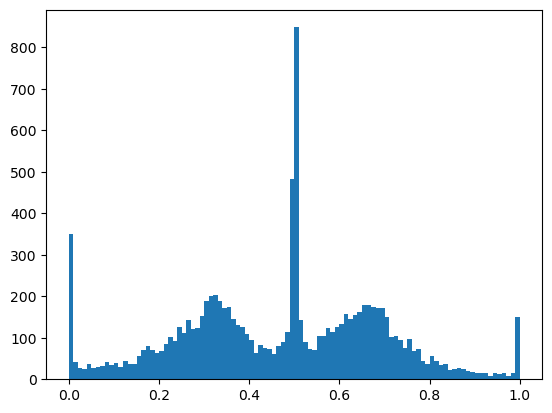

In [72]:
plt.hist(Ytr,bins=100)
plt.show()

### Creating the model
To start we will train a basic model with these parameters:
3

In [75]:
model = models.Sequential()
model.add(layers.Input(shape=(8, 8, 13)))
#model.add(layers.Conv2D(64, (8, 3), activation='relu', input_shape=(8, 8, 13)))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(32, activation=tf.nn.relu))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 8, 8, 32)          3776      
                                                                 
 conv2d_45 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 conv2d_46 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_31 (Dense)            (None, 64)                131136    
                                                                 
 dense_32 (Dense)            (None, 128)             

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.callbacks as callbacks

import tensorflow.keras.optimizers as optimizers
#model.compile(optimizer=optimizers.Adam(1e-2), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
model.compile(optimizer=optimizers.Adam(1e-4), loss='mean_squared_error')

#model.summary()
checkpoint_filepath = '/tmp/checkpoint/'
'''
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)
'''
model_checkpointing_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_best_only= True,
)

model.fit(Xtr, Ytr,
          batch_size=10000,
          epochs=500,
          verbose=1,
          validation_split=0.1,
            callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])
model.save('model.h5')

Epoch 1/500
90/90 [==============================] - ETA: 0s - loss: 0.0169

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 129s 1s/step - loss: 0.0169 - val_loss: 0.0140 - lr: 1.0000e-04
Epoch 2/500
90/90 [==============================] - ETA: 0s - loss: 0.0140

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 137s 2s/step - loss: 0.0140 - val_loss: 0.0139 - lr: 1.0000e-04
Epoch 3/500
90/90 [==============================] - ETA: 0s - loss: 0.0139

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 124s 1s/step - loss: 0.0139 - val_loss: 0.0138 - lr: 1.0000e-04
Epoch 4/500
90/90 [==============================] - ETA: 0s - loss: 0.0138

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 123s 1s/step - loss: 0.0138 - val_loss: 0.0136 - lr: 1.0000e-04
Epoch 5/500
90/90 [==============================] - ETA: 0s - loss: 0.0136

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 121s 1s/step - loss: 0.0136 - val_loss: 0.0135 - lr: 1.0000e-04
Epoch 6/500
90/90 [==============================] - ETA: 0s - loss: 0.0135

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 121s 1s/step - loss: 0.0135 - val_loss: 0.0134 - lr: 1.0000e-04
Epoch 7/500
90/90 [==============================] - ETA: 0s - loss: 0.0134

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 122s 1s/step - loss: 0.0134 - val_loss: 0.0133 - lr: 1.0000e-04
Epoch 8/500
90/90 [==============================] - ETA: 0s - loss: 0.0132

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 127s 1s/step - loss: 0.0132 - val_loss: 0.0131 - lr: 1.0000e-04
Epoch 9/500
90/90 [==============================] - ETA: 0s - loss: 0.0132

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 173s 2s/step - loss: 0.0132 - val_loss: 0.0130 - lr: 1.0000e-04
Epoch 10/500
90/90 [==============================] - ETA: 0s - loss: 0.0130

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 169s 2s/step - loss: 0.0130 - val_loss: 0.0129 - lr: 1.0000e-04
Epoch 11/500
90/90 [==============================] - ETA: 0s - loss: 0.0129

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 152s 2s/step - loss: 0.0129 - val_loss: 0.0129 - lr: 1.0000e-04
Epoch 12/500
90/90 [==============================] - ETA: 0s - loss: 0.0128

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 154s 2s/step - loss: 0.0128 - val_loss: 0.0128 - lr: 1.0000e-04
Epoch 13/500
90/90 [==============================] - ETA: 0s - loss: 0.0127

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 156s 2s/step - loss: 0.0127 - val_loss: 0.0126 - lr: 1.0000e-04
Epoch 14/500
90/90 [==============================] - 156s 2s/step - loss: 0.0127 - val_loss: 0.0129 - lr: 1.0000e-04
Epoch 15/500
90/90 [==============================] - ETA: 0s - loss: 0.0127

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 143s 2s/step - loss: 0.0127 - val_loss: 0.0125 - lr: 1.0000e-04
Epoch 16/500
90/90 [==============================] - 144s 2s/step - loss: 0.0125 - val_loss: 0.0128 - lr: 1.0000e-04
Epoch 17/500
90/90 [==============================] - ETA: 0s - loss: 0.0125

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 153s 2s/step - loss: 0.0125 - val_loss: 0.0124 - lr: 1.0000e-04
Epoch 18/500
90/90 [==============================] - ETA: 0s - loss: 0.0124

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 154s 2s/step - loss: 0.0124 - val_loss: 0.0123 - lr: 1.0000e-04
Epoch 19/500
90/90 [==============================] - ETA: 0s - loss: 0.0123

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 156s 2s/step - loss: 0.0123 - val_loss: 0.0123 - lr: 1.0000e-04
Epoch 20/500
90/90 [==============================] - 151s 2s/step - loss: 0.0123 - val_loss: 0.0124 - lr: 1.0000e-04
Epoch 21/500
90/90 [==============================] - ETA: 0s - loss: 0.0123

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 155s 2s/step - loss: 0.0123 - val_loss: 0.0123 - lr: 1.0000e-04
Epoch 22/500
90/90 [==============================] - ETA: 0s - loss: 0.0122

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 156s 2s/step - loss: 0.0122 - val_loss: 0.0121 - lr: 1.0000e-04
Epoch 23/500
90/90 [==============================] - ETA: 0s - loss: 0.0121

INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


INFO:tensorflow:Assets written to: /tmp/checkpoint\assets


90/90 [==============================] - 177s 2s/step - loss: 0.0121 - val_loss: 0.0121 - lr: 1.0000e-04
Epoch 24/500
90/90 [==============================] - ETA: 0s - loss: 0.0121

In [77]:
np.mean(Ytr)

0.4980052760000001

In [78]:
board = chess.Board()
testInput = np.array([boardToInput(board)])
model(testInput)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4970151]], dtype=float32)>

In [79]:
def getMoveTensor(board,moves,model,isBlack):
    bestEval = -2
    bestMove = None
    for move in moves:
        board.push(move)
        val = model(np.array([boardToInput(board)]))
        if isBlack:
            val = 1-val
        if val > bestEval:
            bestMove = move
            bestEval = val
        board.pop()
    return bestEval,bestMove

In [116]:
board =chess.Board()
isBlack = True

In [132]:

isBlack = not isBlack
print()

moves = list(board.legal_moves)
engineMove = getMoveEngine(board,moves,isBlack)
evaluation, AImove =  getMoveTensor(board,moves,model,isBlack)
if isBlack:
    move = AImove
else:
    move = AImove

board.push(move)
'''
print("Model says: " +str(float(evaluation)))
if isBlack:
    print("Engine evaluates it at: " + str(valueToFloat(engine.analyse(board, chess.engine.Limit(depth=1))['score'].white())))
else:
    print("Engine evaluates it at: " + str(valueToFloat(engine.analyse(board, chess.engine.Limit(depth=1))['score'].white())))
'''
print(board)



. r . . k b n r
p . p n p p p p
. . . . . . . .
. . . . . . . .
. . P . . . . .
. . B . . . . .
P P . . . P B P
R N . . K . . R
